In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
from torch.nn.utils import clip_grad_value_
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Subset, TensorDataset
import random

In [12]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.enc_fc1 = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_fc1(x))
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [14]:
# Hyperparameters
input_dim = 28 * 28  # MNIST images
hidden_dim = 256
vae_latent_dim = 50
latent_dim = 50
num_classes = 10
learning_rate = 1e-3
batch_size = 256
num_epochs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

m1 = VAE(input_dim, hidden_dim, vae_latent_dim).to(device)
optimizer_m1 = optim.Adam(m1.parameters(), lr=learning_rate)

train_loader_all = DataLoader(train_dataset, batch_size=256, shuffle=True)

for epoch in range(50):
    m1.train()
    total_loss = 0
    for x, _ in train_loader_all:
        x = x.to(device)
        x_recon, mu, logvar = m1(x)

        #recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss

        optimizer_m1.zero_grad()
        loss.backward()
        optimizer_m1.step()
        total_loss += loss.item()
    print(f"M1 Epoch {epoch+1}, Loss: {total_loss/len(train_loader_all.dataset):.4f}")

Using device: cuda
M1 Epoch 1, Loss: 204.7446
M1 Epoch 2, Loss: 145.8799
M1 Epoch 3, Loss: 131.7612
M1 Epoch 4, Loss: 123.7643
M1 Epoch 5, Loss: 118.7955
M1 Epoch 6, Loss: 115.7674
M1 Epoch 7, Loss: 113.7411
M1 Epoch 8, Loss: 112.4012
M1 Epoch 9, Loss: 111.2196
M1 Epoch 10, Loss: 110.3672
M1 Epoch 11, Loss: 109.6557
M1 Epoch 12, Loss: 108.9420
M1 Epoch 13, Loss: 108.5186
M1 Epoch 14, Loss: 108.0302
M1 Epoch 15, Loss: 107.6678
M1 Epoch 16, Loss: 107.2831
M1 Epoch 17, Loss: 107.0617
M1 Epoch 18, Loss: 106.7947
M1 Epoch 19, Loss: 106.5638
M1 Epoch 20, Loss: 106.3599
M1 Epoch 21, Loss: 106.2069
M1 Epoch 22, Loss: 106.0115
M1 Epoch 23, Loss: 105.8150
M1 Epoch 24, Loss: 105.6868
M1 Epoch 25, Loss: 105.5900
M1 Epoch 26, Loss: 105.4274
M1 Epoch 27, Loss: 105.3040
M1 Epoch 28, Loss: 105.2241
M1 Epoch 29, Loss: 105.0737
M1 Epoch 30, Loss: 104.9839
M1 Epoch 31, Loss: 104.9253
M1 Epoch 32, Loss: 104.8069
M1 Epoch 33, Loss: 104.7237
M1 Epoch 34, Loss: 104.6534
M1 Epoch 35, Loss: 104.5623
M1 Epoch 3

In [16]:
# Compute training latents
train_latents, train_labels = [], []
with torch.no_grad():
    m1.eval()
    for x, y in train_dataset:
        x = x.to(device)
        mu, _ = m1.encode(x)
        train_latents.append(mu.cpu())
        train_labels.append(y)
train_latent_dataset = TensorDataset(torch.stack(train_latents), torch.tensor(train_labels))

# Compute test latents
test_latents, test_labels = [], []
with torch.no_grad():
    for x, y in test_dataset:
        x = x.to(device)
        mu, _ = m1.encode(x)
        test_latents.append(mu.cpu())
        test_labels.append(y)

test_latent_dataset = TensorDataset(
    torch.stack(test_latents),
    torch.tensor(test_labels)
)

In [17]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, latent_dim):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim) #mean of latent dist
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim) #log var of latent dist

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        h = F.relu(self.enc_fc1(combined))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

# Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        logits = self.layer2(h)
        return logits

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super().__init__()
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        combined = torch.cat([z, y], dim=-1)
        h = F.relu(self.dec_fc1(combined))
        x_hat = self.dec_fc2(h)
        return x_hat

In [18]:
# SSL model
class SSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, learning_rate):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.classifier = Classifier(input_dim, hidden_dim, num_classes)
        self.encoder = Encoder(input_dim, num_classes, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, hidden_dim, input_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def classify(self, x):
        return self.classifier(x)

    def encode(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z, y):
        return self.decoder(z, y)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_l, y_l, x_u):
        """
        x_l: labeled data
        y_l: labels
        x_u: unlabeled data

        """
        # Obtain classifier scores for labeled and unlabeled data.
        scores_l = self.classifier(x_l)
        scores_u = self.classifier(x_u)
        y_u_prob = F.softmax(scores_u, dim=1)

        # Labeled part
        y_l_onehot = F.one_hot(y_l, self.num_classes).float()
        z_l, mu_l, logvar_l = self.encode(x_l, y_l_onehot)
        x_recon = self.decode(z_l, y_l_onehot)

        # Unlabeled part
        loss_u_components = []
        for i in range(self.num_classes):
            y_u = torch.full((x_u.size(0),), i, dtype=torch.long, device=x_u.device)
            y_u_onehot = F.one_hot(y_u, self.num_classes).float()
            z_u, mu_u, logvar_u = self.encode(x_u, y_u_onehot)
            x_recon_u = self.decode(z_u, y_u_onehot)

            # Compute ELBO loss for this label.
            loss_u = self.elbo_loss(x_u, x_recon_u, mu_u, logvar_u)
            loss_u_components.append(loss_u.unsqueeze(1))

        loss_u_stack = torch.cat(loss_u_components, dim=1)

        # Weight the losses by the classifier’s predicted probabilities.
        loss_u = torch.sum(y_u_prob * (loss_u_stack + torch.log(y_u_prob + 1e-8)), dim=1)

        # Total Loss
        classification_loss = F.cross_entropy(scores_l, y_l)
        labeled_loss = self.elbo_loss(x_l, x_recon, mu_l, logvar_l)
        unlabeled_loss = loss_u.mean()

        total_loss = labeled_loss.mean() + unlabeled_loss + 0.1 * classification_loss

        return total_loss, scores_u

    def elbo_loss(self, x, x_recon, mu, logvar):
        # KL divergence between latent distribution and standard normal
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        # Reconstruction loss
        #recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=1)
        recon_loss = F.mse_loss(x_recon, x, reduction='none').sum(dim=1)
        return recon_loss + kld

    def train_step(self, x_l, y_l, x_u):
        # Training loop
        self.optimizer.zero_grad()
        loss, _ = self.forward(x_l, y_l, x_u)
        loss.backward()
        clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        # Prediction
        with torch.no_grad():
            scores = self.classifier(x)
        return torch.argmax(scores, dim=1)

    def visualize_latent_tsne(self, dataloader, num_samples=1000):
        self.eval()
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(self.device)
                y_onehot = F.one_hot(y, self.num_classes).float().to(self.device)

                # Get latent representation
                z, _, _ = self.encode(x, y_onehot)

                latents.append(z.cpu())
                labels.append(y.cpu())

                if sum(len(l) for l in latents) >= num_samples:
                    break

        latents = torch.cat(latents)[:num_samples].numpy()
        labels = torch.cat(labels)[:num_samples].numpy()

        # Perform T-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latents)

        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels,
                            cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('T-SNE Visualization of Latent Space')
        plt.show()

    def generate_conditional_samples(self, m1_model, num_samples=10):
        """Generate samples using the full M1+M2 pipeline."""
        self.eval()
        samples = []

        with torch.no_grad():
            for c in range(self.num_classes):
                # Create class label
                y = torch.full((num_samples,), c, device=self.device)
                y_onehot = F.one_hot(y, self.num_classes).float()

                # Sample the latent variable
                z_ssl = torch.randn(num_samples, self.latent_dim, device=self.device)

                # Generate M1 latent variable
                z_m1 = self.decoder(z_ssl, y_onehot)

                # Decode to image space using M1's decoder
                x_gen = m1_model.decode(z_m1)

                samples.append(x_gen.cpu())

        # Plot grid
        fig, axs = plt.subplots(self.num_classes, num_samples,
                              figsize=(num_samples, self.num_classes))

        for row in range(self.num_classes):
            for col in range(num_samples):
                axs[row, col].imshow(samples[row][col].view(28, 28).numpy(),
                                  cmap='gray', vmin=0, vmax=1)
                axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()


## Using all unlabeled dataset

Starting training with 100 labels and 59900 without labels...
Epoch [1/100], Average Loss: 19.7430
Epoch [2/100], Average Loss: 18.8660
Epoch [3/100], Average Loss: 18.5771
Epoch [4/100], Average Loss: 18.1689
Epoch [5/100], Average Loss: 17.8286
Epoch [6/100], Average Loss: 17.6547
Epoch [7/100], Average Loss: 17.2235
Epoch [8/100], Average Loss: 16.9615
Epoch [9/100], Average Loss: 16.6685
Epoch [10/100], Average Loss: 16.6183
Epoch [11/100], Average Loss: 16.7103
Epoch [12/100], Average Loss: 16.4175
Epoch [13/100], Average Loss: 15.9835
Epoch [14/100], Average Loss: 15.7244
Epoch [15/100], Average Loss: 15.6195
Epoch [16/100], Average Loss: 15.3641
Epoch [17/100], Average Loss: 15.3032
Epoch [18/100], Average Loss: 15.3542
Epoch [19/100], Average Loss: 15.4463
Epoch [20/100], Average Loss: 15.0845
Epoch [21/100], Average Loss: 15.0457
Epoch [22/100], Average Loss: 15.1021
Epoch [23/100], Average Loss: 15.2310
Epoch [24/100], Average Loss: 15.0345
Epoch [25/100], Average Loss: 14.86

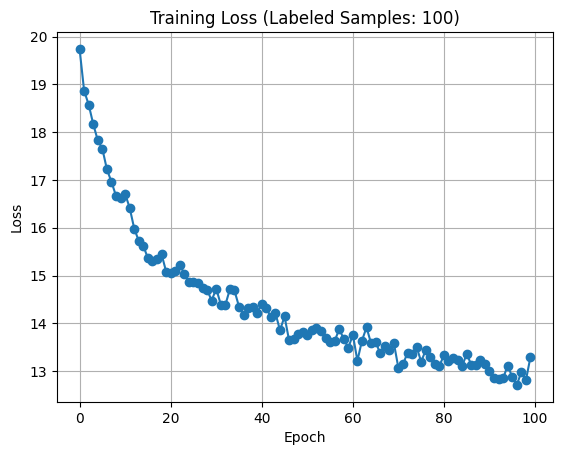

Test Accuracy (100 labels): 88.91%


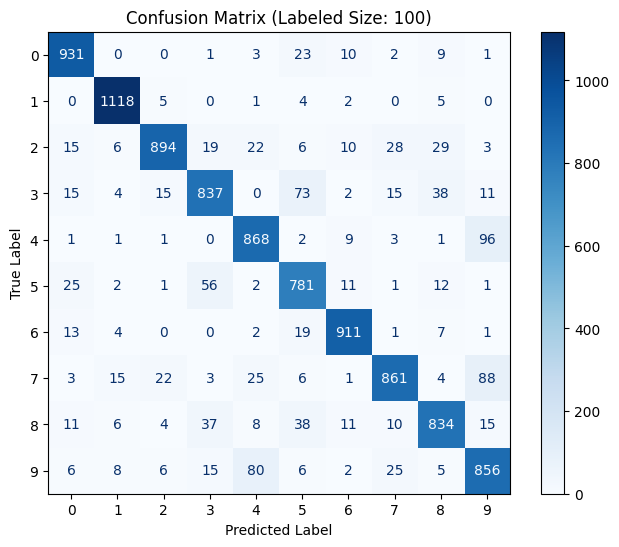

----------------------------------------------------------------
Starting training with 1000 labels and 59000 without labels...
Epoch [1/100], Average Loss: 18.9049
Epoch [2/100], Average Loss: 17.6375
Epoch [3/100], Average Loss: 16.7885
Epoch [4/100], Average Loss: 16.1392
Epoch [5/100], Average Loss: 15.5686
Epoch [6/100], Average Loss: 15.2070
Epoch [7/100], Average Loss: 14.9274
Epoch [8/100], Average Loss: 14.8147
Epoch [9/100], Average Loss: 14.6707
Epoch [10/100], Average Loss: 14.4893
Epoch [11/100], Average Loss: 14.4691
Epoch [12/100], Average Loss: 14.3376
Epoch [13/100], Average Loss: 14.2929
Epoch [14/100], Average Loss: 14.1882
Epoch [15/100], Average Loss: 14.0917
Epoch [16/100], Average Loss: 14.0066
Epoch [17/100], Average Loss: 13.8967
Epoch [18/100], Average Loss: 13.8512
Epoch [19/100], Average Loss: 13.7538
Epoch [20/100], Average Loss: 13.7253
Epoch [21/100], Average Loss: 13.6388
Epoch [22/100], Average Loss: 13.6497
Epoch [23/100], Average Loss: 13.5218
Epoch [

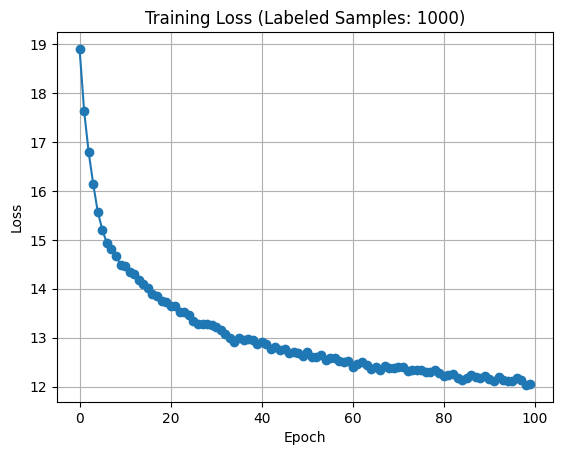

Test Accuracy (1000 labels): 95.08%


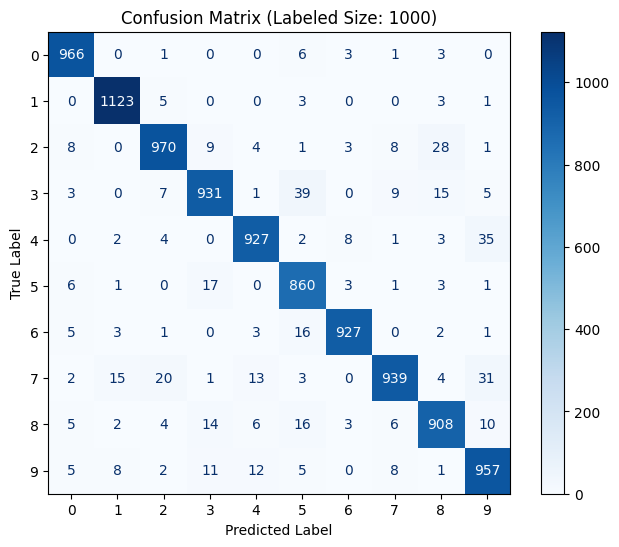

----------------------------------------------------------------
Starting training with 3000 labels and 57000 without labels...
Epoch [1/100], Average Loss: 18.6738
Epoch [2/100], Average Loss: 16.9719
Epoch [3/100], Average Loss: 15.8170
Epoch [4/100], Average Loss: 15.0756
Epoch [5/100], Average Loss: 14.7346
Epoch [6/100], Average Loss: 14.5593
Epoch [7/100], Average Loss: 14.3624
Epoch [8/100], Average Loss: 14.1932
Epoch [9/100], Average Loss: 14.0768
Epoch [10/100], Average Loss: 13.9323
Epoch [11/100], Average Loss: 13.7898
Epoch [12/100], Average Loss: 13.6807
Epoch [13/100], Average Loss: 13.5592
Epoch [14/100], Average Loss: 13.4591
Epoch [15/100], Average Loss: 13.3967
Epoch [16/100], Average Loss: 13.2706
Epoch [17/100], Average Loss: 13.2430
Epoch [18/100], Average Loss: 13.1295
Epoch [19/100], Average Loss: 13.0873
Epoch [20/100], Average Loss: 13.0016
Epoch [21/100], Average Loss: 12.9484
Epoch [22/100], Average Loss: 12.9130
Epoch [23/100], Average Loss: 12.8688
Epoch [

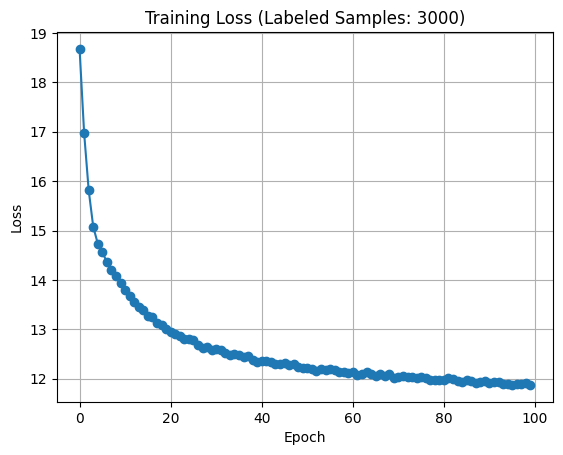

Test Accuracy (3000 labels): 95.71%


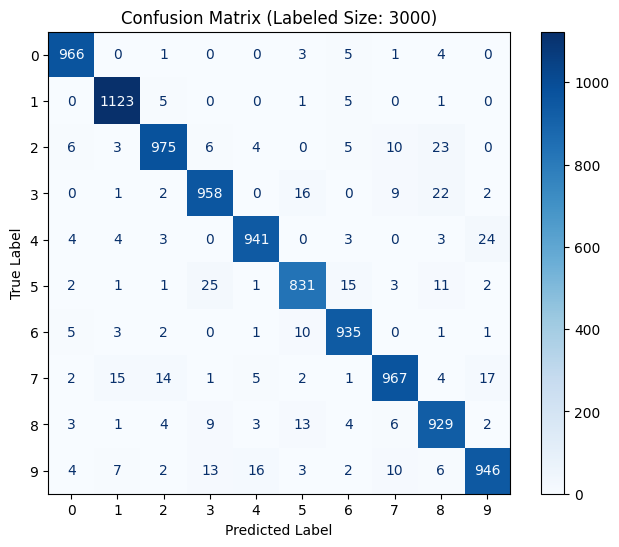

----------------------------------------------------------------


In [19]:
labels_list = [100, 1000, 3000] # Different label size

num_classes = 10

# # Create a semi-supervised split: We make the classes balanced in the supervised labels.

for labeled_size in labels_list:
    per_class = labeled_size // num_classes

    latent_targets = train_latent_dataset.tensors[1]

    labeled_indices = []
    for c in range(num_classes):

        c_indices = (latent_targets == c).nonzero(as_tuple=True)[0]

        c_indices = c_indices[torch.randperm(len(c_indices))]

        labeled_indices.extend(c_indices[:per_class].tolist())


    all_indices = set(range(len(train_latent_dataset)))

    unlabeled_indices = list(all_indices - set(labeled_indices))

    labeled_dataset = Subset(train_latent_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_latent_dataset, unlabeled_indices)

    if labeled_size == 100:
        batch_size_labeled = 1
        batch_size = 599
    elif labeled_size == 1000:
        batch_size_labeled = 10
        batch_size = 590
    elif labeled_size == 3000:
        batch_size_labeled = 30
        batch_size = 570

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled,
                                shuffle=True, pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size,
                                  shuffle=True, pin_memory=True)

    model = SSL(50, hidden_dim, latent_dim, num_classes, learning_rate)
    model = model.to(device)
    epoch_losses = []

    # Training loop
    print(f"Starting training with {labeled_size} labels and {len(train_dataset)-labeled_size} without labels...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        labeled_samples_count = 0
        unlabeled_samples_count = 0

        for (z_l, y_l), (z_u, _) in zip(labeled_loader, unlabeled_loader):
            # Update counters
            num_batches += 1
            labeled_samples_count += z_l.size(0)
            unlabeled_samples_count += z_u.size(0)

            z_l = z_l.to(device)
            y_l = y_l.to(device)
            z_u = z_u.to(device)

            loss = model.train_step(z_l, y_l, z_u)
            total_loss += loss

        avg_loss = total_loss / (len(labeled_loader)+len(unlabeled_loader))
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    print(f"  Processed {num_batches} batches per epoch: {labeled_samples_count} labeled samples, {unlabeled_samples_count} unlabeled samples")

    # Plot training loss curve
    plt.figure()
    plt.plot(epoch_losses, marker='o')
    plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # # Evaluate on test data.
    test_loader = DataLoader(test_latent_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for z, y in test_loader:
            z = z.to(device)
            y = y.to(device)
            preds = model.predict(z)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
    print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')

    ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    print('----------------------------------------------------------------')




Generating latent space visualization...


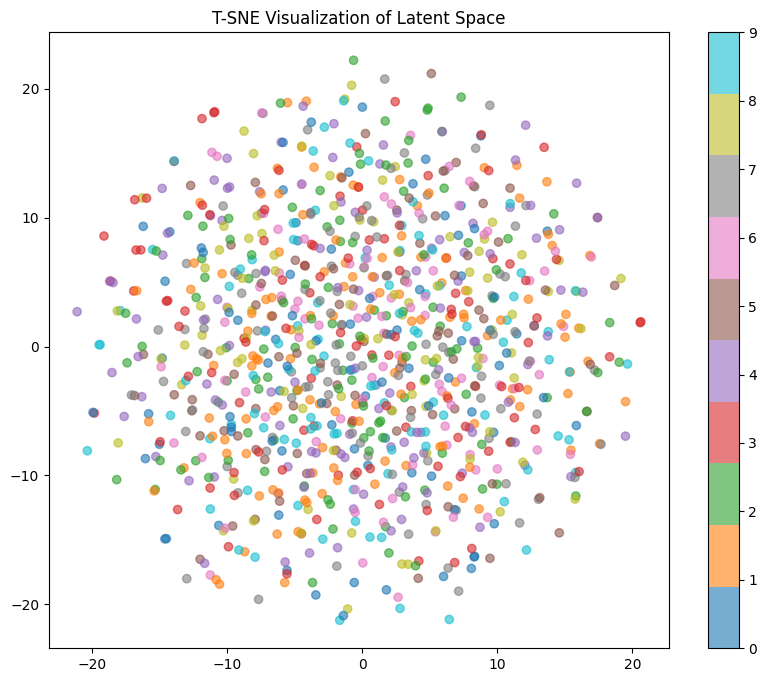

In [21]:
print("Generating latent space visualization...")
model.visualize_latent_tsne(test_loader)

Generating conditional samples...


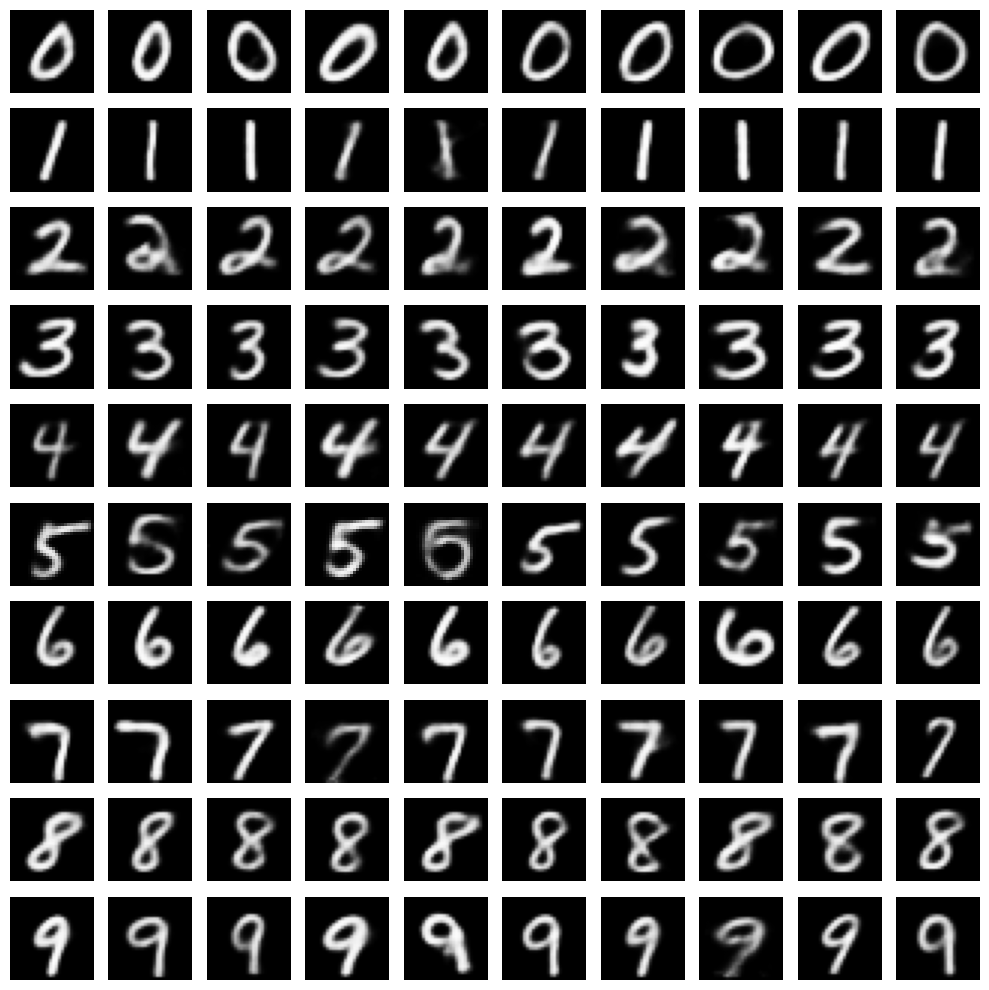

In [22]:
print("Generating conditional samples...")
model.generate_conditional_samples(m1_model=m1, num_samples=10)